In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import scipy.io.wavfile as wav

In [2]:
if sys.version_info[0] < 3:
    # for Python 2
    import cPickle as pickle
else:
    # for Python 3
    import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device=", device)  

device= cpu


In [3]:
def signal2pytorch(x):
    #Function to convert a signal vector x, like a mono audio signal, into a 3-d Tensor that conv1d of Pytorch expects,
    #Argument x: a 1-d signal as numpy array
    #input x[batch,sample]
    #output: 3-d Tensor X for conv1d input.
    #for conv1d Input: (N,Cin,Lin), Cin: numer of input channels (e.g. for stereo), Lin: length of signal, N: number of Batches (signals) 
    X = np.expand_dims(x, axis=0)  #add channels dimension (here only 1 channel)
    if len(x.shape)==1: #mono:
        X = np.expand_dims(X, axis=0)  #add batch dimension (here only 1 batch)
    X=torch.from_numpy(X)
    X=X.type(torch.Tensor)
    X=X.permute(1,0,2)  #make batch dimension first
    return X

In [4]:
class Convautoenc(nn.Module):
    def __init__(self):
        super(Convautoenc, self).__init__()
        #Analysis Filterbank with downsampling of N=8*1024, filter length of 2N, but only 32 outputs:
        #for the mean values:
        self.conv1mean=nn.Conv1d(in_channels=1, out_channels=32, kernel_size=8*2048, stride=8*1024, padding=8*1024-1, bias=True) #Padding for 'same' filters (kernel_size/2-1)
        #for the standard deviation values:
        self.conv1std=nn.Conv1d(in_channels=1, out_channels=32, kernel_size=8*2048, stride=8*1024, padding=8*1024-1, bias=True) #Padding for 'same' filters (kernel_size/2-1)
        #Synthesis filter bank:
        self.synconv1=nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=8*2048, stride=8*1024, padding=8*1024-1, bias=True)

    def encodermean(self, x):
        #Analysis:
        x = self.conv1mean(x)
        y = torch.tanh(x)
        return y
      
    def encoderstd(self, x):
        #Analysis:
        x = self.conv1std(x)
        y = torch.abs(torch.tanh(x))
        return y
      
    def decoder(self, y):
        #Synthesis:
        xrek= self.synconv1(y)
        return xrek
      
    def forward(self, x):
        Yencmean=model.encodermean(x)
        Yencstd=model.encoderstd(x)
        Yvariational= Yencmean + Yencstd*torch.randn_like(Yencstd)
        Ypred=model.decoder(Yvariational)
        return Ypred, Yencmean, Yencstd

In [5]:
def variational_loss(mu, std):
    #returns the varialtional loss from arguments mean and standard deviation std
    vl=-0.5*torch.mean(1+ 2*torch.log(std)-mu.pow(2) -(std.pow(2)))
    return vl

In [6]:
import librosa

In [7]:
#alternative: speech:
#make training set with batch of 2 speech signals:
batch=2;
fs, x0= wav.read('/content/drive/MyDrive/recordings/a0001.wav') #get size of the speech files, all need to be identical
xlen=max(x0.shape)
x=np.zeros((batch,xlen))
for b in range(batch):
    if b==0: 
        fs, x0= wav.read('/content/drive/MyDrive/recordings/a0001.wav')
    if b==1:
        fs, x0= wav.read('/content/drive/MyDrive/recordings/a0001.wav')
    x0= x0/max(x0)
    x[b,:]=x0
    print("x.shape=", x.shape)
    X=signal2pytorch(x).to(device) #Convert to pytorch format, batch is first dimension    
    print("X.shape=", X.shape)
    print("Generate Model:")
    model = Convautoenc().to(device)
    print('Total number of parameters: %i' % (sum(p.numel() for p in model.parameters() if p.requires_grad)))
    print("Def. loss function:")
    loss_fn = nn.MSELoss()  #MSE

x.shape= (2, 71332)
X.shape= torch.Size([2, 1, 71332])
Generate Model:
Total number of parameters: 1572929
Def. loss function:
x.shape= (2, 71332)
X.shape= torch.Size([2, 1, 71332])
Generate Model:
Total number of parameters: 1572929
Def. loss function:


In [8]:
Ypred, Yencmean, Yencstd = model(X)

outputlen=len(Ypred[0,0,:]) #length of the signal at the output of the network.
print("outputlen=", outputlen)
    
Y=X[:,:,:outputlen]  #the target signal with same length as model output
    
print("Input X.shape=", X.shape )
print("Target Y.shape=", Y.shape)
print("Target Y=", Y)
print("Y.type()=", Y.type())
        
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, betas=(0.9, 0.999))
randdir=False

outputlen= 65538
Input X.shape= torch.Size([2, 1, 71332])
Target Y.shape= torch.Size([2, 1, 65538])
Target Y= tensor([[[-0.0100, -0.0196, -0.0151,  ..., -0.0067, -0.0031, -0.0048]],

        [[-0.0100, -0.0196, -0.0151,  ..., -0.0067, -0.0031, -0.0048]]])
Y.type()= torch.FloatTensor


In [9]:
if randdir==True:
    #optimization of weights using method of random directions:
    optimrandomdir_pytorch.optimizer(model, loss_fn, X, Y, iterations=100000, startingscale=0.25, endscale=0.0)

else:
    for epoch in range(2000):
        #mean values from the encoder network:
        Yencmean=model.encodermean(X)
          
        #standard deviation values from the network:
        Yencstd=model.encoderstd(X)

        Yvariational= Yencmean + Yencstd*torch.randn_like(Yencstd)
        Ypred=model.decoder(Yvariational)
          
        mse=loss_fn(Ypred, Y)
        vl=variational_loss(Yencmean, Yencstd)
        loss= mse + 0.01*vl
        if epoch%10==0:
             print(epoch, "mse=", mse.item(), "variational loss=", vl.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    torch.save({#'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()}, "audio_variational_autoenc.torch")


0 mse= 0.010807819664478302 variational loss= 3.0673441886901855
10 mse= 0.010477296076714993 variational loss= 0.9233275651931763
20 mse= 0.009371100924909115 variational loss= 0.6125625371932983
30 mse= 0.007950243540108204 variational loss= 0.5154788494110107
40 mse= 0.006670708768069744 variational loss= 0.47782912850379944
50 mse= 0.005295925308018923 variational loss= 0.4536628723144531
60 mse= 0.004485894925892353 variational loss= 0.4341391324996948
70 mse= 0.003411283018067479 variational loss= 0.4158223867416382
80 mse= 0.002832582453265786 variational loss= 0.3991762697696686
90 mse= 0.0025251763872802258 variational loss= 0.38388586044311523
100 mse= 0.002674076007679105 variational loss= 0.37064874172210693
110 mse= 0.0024028958287090063 variational loss= 0.35668694972991943
120 mse= 0.002538863802328706 variational loss= 0.3510812520980835
130 mse= 0.002002227585762739 variational loss= 0.34158605337142944
140 mse= 0.0019035383593291044 variational loss= 0.321511059999465

MSE= 0.0015003979206085205 Variational Loss: 0.1913997083902359
ww= OrderedDict([('conv1mean.weight', tensor([[[ 2.6682e-03,  5.4256e-03,  1.5661e-03,  ..., -1.2201e-03,
          -1.2451e-03,  5.0868e-03]],

        [[-2.3927e-03,  6.4989e-03, -6.6701e-03,  ..., -6.2399e-03,
           1.7234e-04, -8.7513e-03]],

        [[-6.8749e-05, -7.0163e-03, -4.5795e-03,  ..., -4.5815e-04,
           1.7227e-03, -3.2888e-04]],

        ...,

        [[ 1.8942e-03, -9.6349e-03,  4.7980e-03,  ...,  2.7029e-03,
           7.3926e-03,  2.6048e-03]],

        [[-4.7438e-03, -2.9289e-03,  4.5055e-03,  ..., -1.5247e-03,
          -4.6512e-03, -8.8477e-04]],

        [[ 1.5741e-03, -4.7106e-03,  3.1911e-03,  ..., -8.3261e-04,
           3.4567e-03, -5.5310e-03]]])), ('conv1mean.bias', tensor([ 0.0023,  0.0001, -0.0028,  0.0034, -0.0021, -0.0040,  0.0007, -0.0048,
        -0.0022, -0.0044,  0.0063,  0.0052,  0.0071,  0.0028,  0.0052, -0.0077,
        -0.0075,  0.0029, -0.0041,  0.0049, -0.0105, -0.0113,

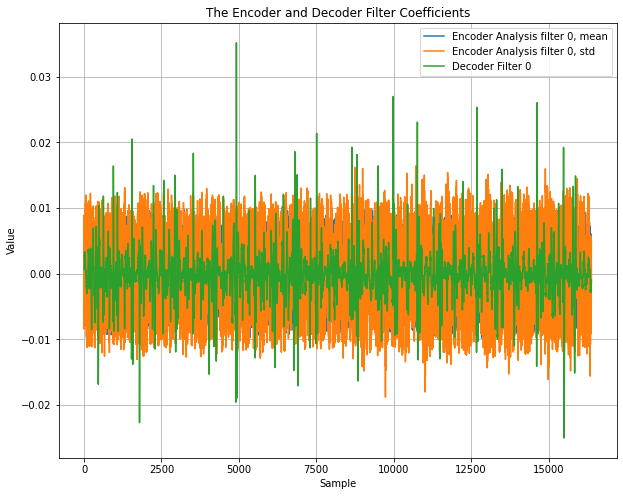

In [10]:
print("MSE=", loss_fn(Ypred, Y).item(), "Variational Loss:", variational_loss(Yencmean, Yencstd).item())
ww = model.state_dict()   #read obtained weights
print("ww=", ww)
#Plot obtained weights:
plt.figure(figsize=(10,8))
plt.plot(np.transpose(np.array(ww['conv1mean.weight'][0:1,0,:])))
plt.plot(np.transpose(np.array(ww['conv1std.weight'][0:1,0,:])))
plt.plot(np.transpose(np.array(ww['synconv1.weight'][0:1,0,:])))
plt.legend(('Encoder Analysis filter 0, mean','Encoder Analysis filter 0, std', 'Decoder Filter 0'))
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('The Encoder and Decoder Filter Coefficients')
plt.grid()

In [11]:
#Test on training set:

#noisy case:
Yencmean=model.encodermean(X)
    
#no noise case
predclean=model.decoder(Yencmean)
predclean=predclean.detach() #no noise case
predclean=np.array(predclean)
    
#Add gaussian noise with unit standard deviation to encoded signal:
Yvariational= Yencmean + torch.randn_like(Yencmean)
predictions=model.decoder(Yvariational)
    
predictions=predictions.detach()
predictions=np.array(predictions)
Yencmean=np.array(Yencmean.detach())
Yencstd=np.array(Yencstd.detach())
print("Yencstd.shape=",Yencstd.shape)
    
Y=np.array(Y) 
print("predictions.shape=", predictions.shape)

Yencstd.shape= (2, 32, 9)
predictions.shape= (2, 1, 65538)


In [12]:
import IPython.display as ipd

"The training set output for clean encoded signal for batch0"


"The training set output for noisy encoded signal for batch0"


"The training set output for clean encoded signal for batch1"


"The training set output for noisy encoded signal for batch1"


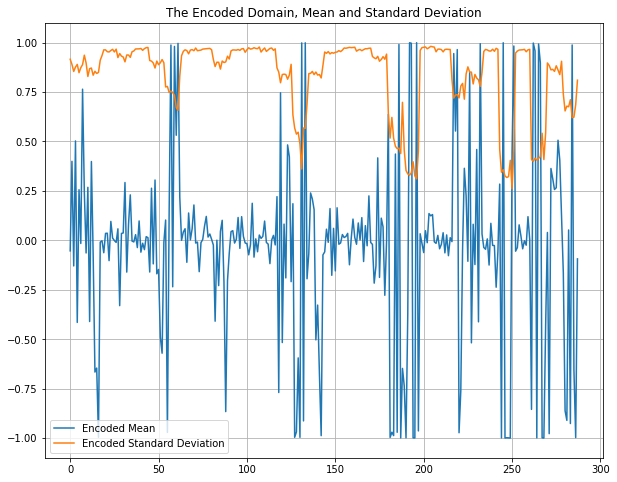

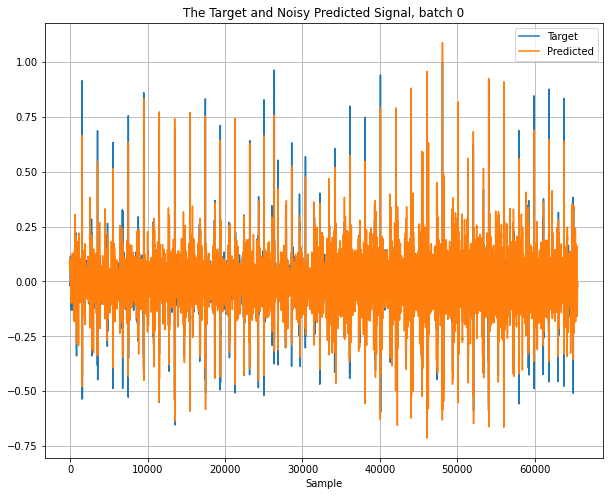

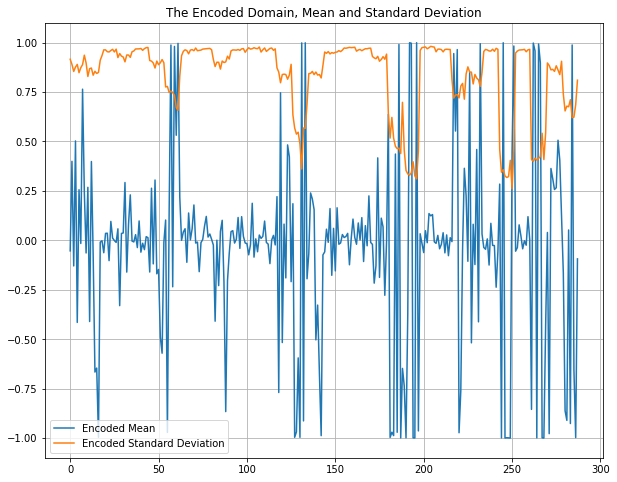

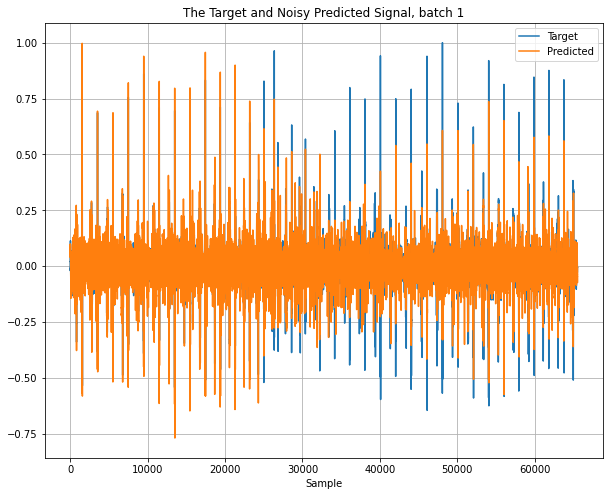

In [13]:
#Plot target signal and output of autoencoder:

for b in range(batch):
    plt.figure(figsize=(10,8))
    plt.plot(np.reshape(Yencmean[b,:,:],(1,-1))[0,:])
    plt.plot(np.reshape(Yencstd[b,:,:],(1,-1))[0,:])
    plt.legend(('Encoded Mean', 'Encoded Standard Deviation'))
    plt.title('The Encoded Domain, Mean and Standard Deviation')
    plt.grid()
    plt.figure(figsize=(10,8))
    plt.plot(np.array(Y[b,0,:]))
    plt.plot(predictions[b,0,:])
    plt.legend(('Target','Predicted'))
    plt.title('The Target and Noisy Predicted Signal, batch '+str(b))
    plt.xlabel('Sample')
    plt.grid()

    #No noise case:
    xrek=predclean[b,0,:]  #remove unnecessary dimension
    xrek=np.clip(xrek, -1.0,1.0)
    wav.write('testrekvaeclean'+str(b)+'.wav', fs, np.int16(2**15*xrek))
    print('"The training set output for clean encoded signal for batch'+str(b)+'"')
    display(ipd.Audio(2**15*xrek,rate=fs))
      
    xrek=predictions[b,0,:]  #remove unnecessary dimension
    xrek=np.clip(xrek, -1.0,1.0)
    wav.write('testrekvae'+str(b)+'.wav', fs, np.int16(2**15*xrek))
    print('"The training set output for noisy encoded signal for batch'+str(b)+'"')
    display(ipd.Audio(2**15*xrek,rate=fs))